<a href="https://colab.research.google.com/github/prometheus-eco-racing/embedded-ai-sfhmmy22-att/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Python Environment 

The next cell sets up the dependencies in required for the notebook, run it.

In [2]:
!apt-get -qq install xxd
!pip3 install pandas numpy matplotlib
!pip3 install tensorflow

from locale import normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# Upload Data

Create a `data` folder and upload the `balanced.csv` and `unbalanced.csv` files you just created.

Sometimes copy-paste from arduino serial monitor adds a second newline. Uncomment and run the following cell to consume them:

In [3]:
# import sys
# for fpath in ["data/balanced.csv", "data/unbalanced.csv"]:
#     with open(fpath) as fin, open(fpath+"2", 'w+') as fout:
#         for line in fin:
#             if not line.isspace():
#                 fout.write(line)

# Plot the data

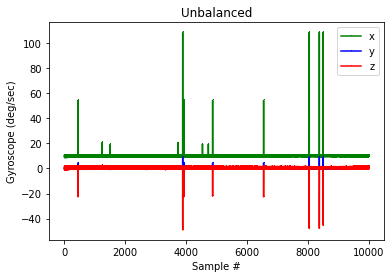

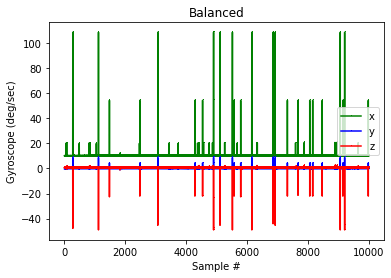

In [4]:
df_unbalanced = pd.read_csv("data/unbalanced.csv")
df_balanced = pd.read_csv("data/balanced.csv")

plt.figure()
plt.plot(df_unbalanced['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(df_unbalanced['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(df_unbalanced['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Unbalanced")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()

plt.figure()
plt.plot(df_balanced['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(df_balanced['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(df_balanced['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Balanced")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

# Train the Neural Network

## Preprocess the dataset

The next cell parses the csv files and transforms them to a format that will be used to train the full connected neural network.

In [5]:
CLASS = [
    "balanced",
    "unbalanced",
]

MSR_SERIES_PER_SAMPLE = 10 # number of measurement series (6) per sample

inputs = []
outputs = []

# read each csv file and push an input and output
for output_class in CLASS:
  output = 1 if output_class == "balanced" else 0
  print(f"Processing output_class '{output_class}'.")

  df = pd.read_csv("data/" + output_class + ".csv", dtype=float)

  # calculate the number of dataset samples for the current class
  num_samples = int(df.shape[0] / MSR_SERIES_PER_SAMPLE)
  
  print(f"\tThere are {num_samples} samples of the {output_class} output_class in the dataset.")


  for i in range(num_samples):
    tensor = []
    for j in range(MSR_SERIES_PER_SAMPLE):
      index = i * MSR_SERIES_PER_SAMPLE + j

      tensor += [
          df['aX'][index], 
          df['aY'][index], 
          df['aZ'][index], 
          df['gX'][index], 
          df['gY'][index], 
          df['gZ'][index],
          ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

Processing output_class 'balanced'.
	There are 1000 samples of the balanced output_class in the dataset.
Processing output_class 'unbalanced'.
	There are 1000 samples of the unbalanced output_class in the dataset.
Data set parsing and preparation complete.


## Randomize and split the input and output pairs for training

Randomly sprint the input and ouput pairs into sets of data. 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used test the model after training

In [6]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
randomize = np.arange(len(inputs))
np.random.shuffle(randomize)
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * len(inputs))
TEST_SPLIT = int(0.2 * len(inputs) + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print(len(inputs_train))
print(len(inputs_test))
print(len(inputs_validate))

1200
400
400


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [7]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(15, activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
history = model.fit(inputs_train, outputs_train, epochs=60, batch_size=32, validation_data=(inputs_validate, outputs_validate))

Epoch 1/60
38/38 [==============================] - 1s 8ms/step - loss: 0.9517 - accuracy: 0.5167 - val_loss: 0.8232 - val_accuracy: 0.4950
Epoch 2/60
38/38 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.5142 - val_loss: 0.7638 - val_accuracy: 0.5850
Epoch 3/60
38/38 [==============================] - 0s 4ms/step - loss: 0.6741 - accuracy: 0.5492 - val_loss: 0.7847 - val_accuracy: 0.5500
Epoch 4/60
38/38 [==============================] - 0s 6ms/step - loss: 0.6790 - accuracy: 0.5600 - val_loss: 0.7646 - val_accuracy: 0.5975
Epoch 5/60
38/38 [==============================] - 0s 4ms/step - loss: 0.6615 - accuracy: 0.5783 - val_loss: 0.7621 - val_accuracy: 0.6050
Epoch 6/60
38/38 [==============================] - 0s 4ms/step - loss: 0.6511 - accuracy: 0.6167 - val_loss: 0.7710 - val_accuracy: 0.4950
Epoch 7/60
38/38 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6625 - val_loss: 0.7477 - val_accuracy: 0.7500
Epoch 8/60
38/38 [==

## Verify 

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

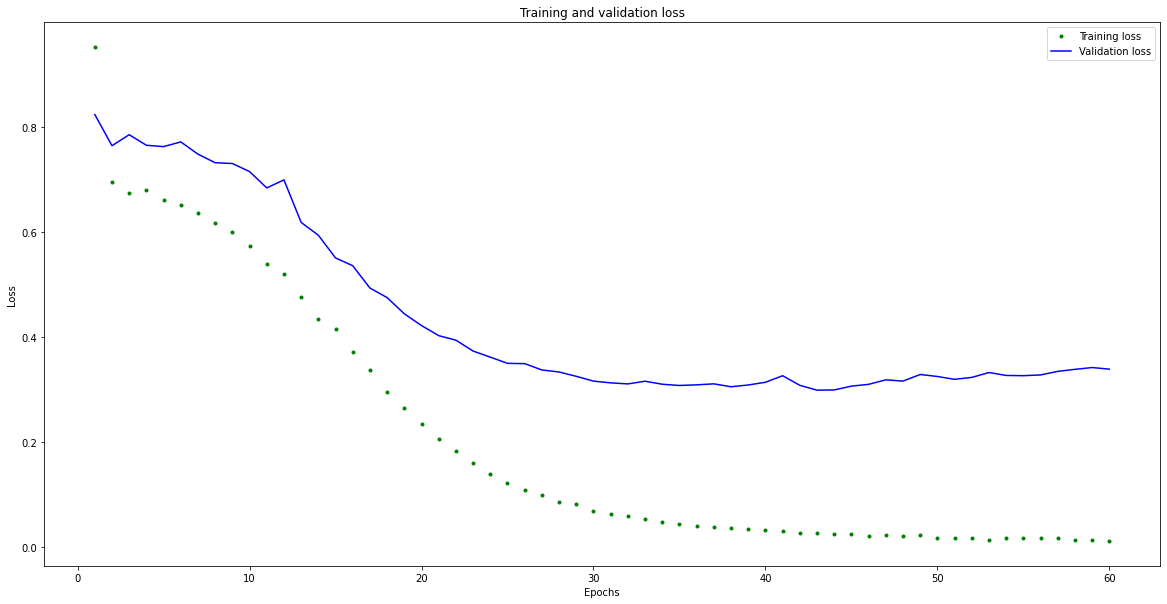

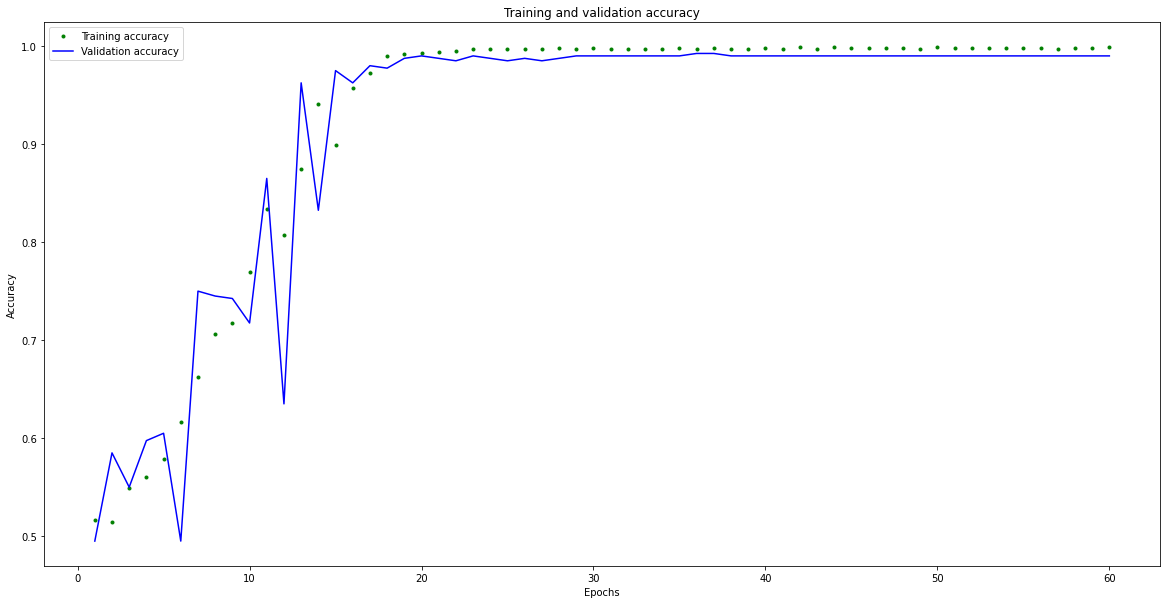

In [8]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'g.', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Run with Test Data
Put our test data into the model and plot the predictions


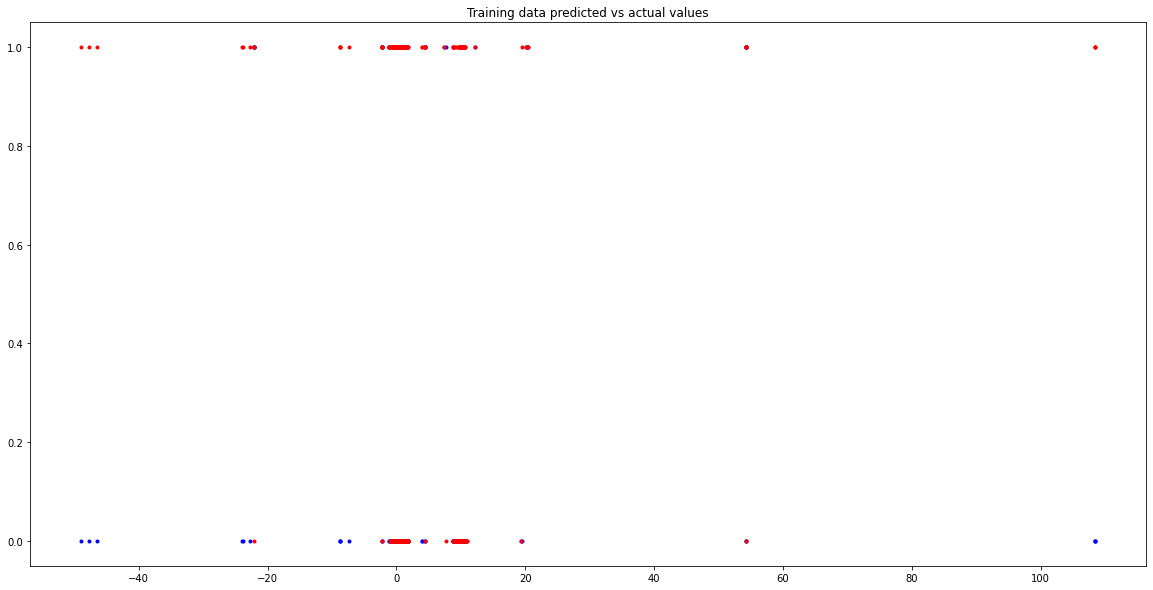

In [9]:
# use the model to predict the test inputs
predictions = np.array((model.predict(inputs_test) > 0.5)[:], dtype=int)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
plt.plot(inputs_test, predictions, 'r.', label='Predicted')
plt.show()

# Convert the Trained Model to Tensorflow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [10]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("model.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: /tmp/tmpnqb74bn6/assets


Model is 17128 bytes


## Encode the Model in an Arduino Header File 

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [13]:
!echo -n "//Build time: "                    > model.h 
!date "+%T"                                 >> model.h
!echo "const unsigned char model[] = {"     >> model.h
!cat model.tflite | xxd -i                  >> model.h
!echo "};"                                  >> model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 105,680 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
